# Проверка влияния параметров и выбросов на уровень ошибки при прогнозе по модели

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Чтение "широких" данных
data = pd.read_excel('data_for_model.xlsx')
data = data.dropna()
# Дополнительный параметр (изменение МНО)
data['trend'] = data['INR(MHO)'] - data['prev_INR(MHO)']
data.head()

,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31,trend
0,140361892057136,57,7.50,3.11,1,0,0,13,3.32,1,...,0,0,0,0,0,0,0,0,0,0.21
1,140361892057136,57,7.50,3.32,1,0,0,15,2.01,2,...,0,0,0,0,0,0,0,0,0,-1.31
2,140361892057264,50,5.00,2.01,0,1,0,26,2.75,1,...,0,0,0,0,0,0,0,0,0,0.74
3,140361892057392,53,6.25,1.42,1,0,0,15,2.56,1,...,0,0,0,0,0,0,0,0,0,1.14
4,140361892057392,53,6.25,2.56,1,0,0,49,2.80,2,...,0,0,0,0,0,0,0,0,0,0.24


In [4]:
# Общие параметры для проверок

RANDOM_STATE = 0
MAX_TIME = 3600
JOBS = 4

base_cols = ['id', 'age', 'prev_INR(MHO)', 'dose', 'atrial_fibrillation', 'mitral_valve',
             'aortal_valve', 'date_diff', 'INR(MHO)', 'sample', 'pass_dose', 
             'gender_0', 'gender_1', 'critical_age_l', 'critical_age_h'
#            ,'agebin_1', 'agebin_2', 'agebin_3', 'agebin_4','agebin_5', 'agebin_6', 'agebin_7', 'agebin_8'
            ]

tgt_col = 'dose'
# Дополнительные колонки для проверки влияния на прогноз
prd_cols = ['trend', 'pred', 'diff', 'mape']


### Прогноз по выбраной модели

Модель представляет собой самый точный пайплайн, подобранный в другом блокноте

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders.ordinal import OrdinalEncoder
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from sklearn.cluster import FeatureAgglomeration
from sklearn.neighbors import KNeighborsRegressor
from category_encoders.one_hot import OneHotEncoder
from numpy import nan
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.preprocessing import MinMaxScaler

In [6]:
# Уточнение состава колонок набора данных
# Для этого этапа проверки количество колонок сокращается до базового набора + trend

cols =base_cols+['trend'] 
data = data[cols]
data.head(3)

,id,age,prev_INR(MHO),dose,atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,pass_dose,gender_0,gender_1,critical_age_l,critical_age_h,trend
0,140361892057136,57,3.11,7.5,1,0,0,13,3.32,1,0,1,0,0,17,0.21
1,140361892057136,57,3.32,7.5,1,0,0,15,2.01,2,0,1,0,0,17,-1.31
2,140361892057264,50,2.01,5.0,0,1,0,26,2.75,1,0,0,1,0,10,0.74


Одной из проверок была на влияние нормализации данных на точность прогноза.
Опытным путем выяснено, что принудительная нормализация (MinMaxScaler) влияния на точность не оказывает, вероятно, GAMA сама выполняет нормализации на этапе препроцессинга (???).

In [7]:
# scalerX = MinMaxScaler()
# scalerY = MinMaxScaler()

# df=data.copy()
# norm_cols = ['age', 'prev_INR(MHO)','date_diff', 'INR(MHO)','trend', 'critical_age_l', 'critical_age_h']
# df[norm_cols] = scalerX.fit_transform(df[norm_cols])
# df[['dose_n']] = scalerY.fit_transform(df[['dose']])

# df.head()

## df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
## df.head()

In [8]:
df = data.copy()

Средняя абсолютная ошибка (MAE):                         0.36
Среднеквадратичная ошибка (MSE):                         0.66
Коэффициент детерминации (R^2):                          0.73
Средняя абсолютная процентная ошибка (MAPE):            13.32%
Доля предсказаний с отклонением не более 0,5 мг:        72.60%


C:\Users\Sovtsov\AutoML\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


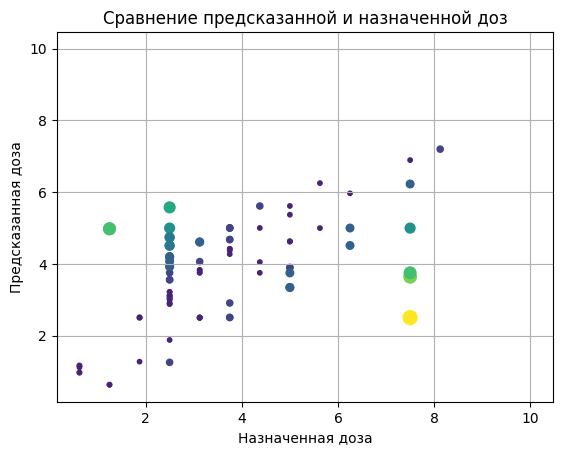

In [9]:
# Подготовка данных для прогноза

# Разделение данных на обучающий и тестовый наборы (не используя функцию simplified_stratified_split)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

# Опытным путем проверено, что наибольшая точность получается, если удалить из X,
# следующий набор колонок:

features2remove = ['dose','pass_dose','sample','date_diff']

X_train = train_df.drop(columns=features2remove, axis=1)
y_train = train_df['dose']
X_test = test_df.drop(columns=features2remove, axis=1)
y_test = test_df['dose']

# Подобранный ранее пайплайн для регресии
pipe = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='manhattan', linkage='average')),
('0', KNeighborsRegressor(n_neighbors=93, p=1, weights='distance'))])

# Обучение пайплайна 
pipe.fit(X_train, y_train)

### Прогноз и расчет точности на полном наборе данных
# X_test = df.drop(columns=features2remove, axis=1)
# y_test = df['dose']

# предсказание
predictions = pipe.predict(X_test)
rpredictions = [round(x,3) for x in predictions] # округление до точности исходных данных

# Рассчитываем основные метрики
mae = mean_absolute_error(y_test, rpredictions)
mse = mean_squared_error(y_test, rpredictions)
r2 = r2_score(y_test, rpredictions)
mape_value = np.mean(np.abs((y_test - rpredictions) / y_test)) * 100
abs_diff = np.abs(y_test - rpredictions)
diff_below_threshold = (abs_diff <= 0.5).sum()
total_predictions = len(rpredictions)
percentage_diff = (diff_below_threshold / total_predictions) * 100

# Выводим результаты
print("{:<55} {:>5.2f}".format("Средняя абсолютная ошибка (MAE):", mae))
print("{:<55} {:>5.2f}".format("Среднеквадратичная ошибка (MSE):", mse))
print("{:<55} {:>5.2f}".format("Коэффициент детерминации (R^2):", r2))
print("{:<55} {:>5.2f}%".format("Средняя абсолютная процентная ошибка (MAPE):", mape_value))
print("{:<55} {:>5.2f}%".format("Доля предсказаний с отклонением не более 0,5 мг:", percentage_diff))

ae = round(abs(y_test - rpredictions)/0.5)
col = ae
size = ae*10
plt.scatter(y_test, rpredictions, marker='o', c=col,  s=size)
plt.title('Сравнение предсказанной и назначенной доз')
plt.ylabel('Предсказанная доза')
plt.xlabel('Назначенная доза');
plt.grid()
plt.show()


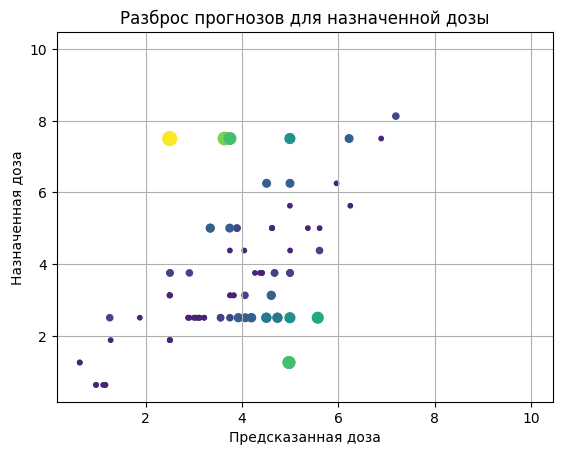

In [10]:
# разброс прогнозов по назначенной дозе
col = ae
size = ae*10
plt.scatter(rpredictions, y_test, marker='o', c=col,  s=size)
plt.title('Разброс прогнозов для назначенной дозы')

plt.xlabel('Предсказанная доза')
plt.ylabel('Назначенная доза');
plt.grid()
plt.show()

In [11]:
# Проверка совпадения размерностей и отсутствия пропусков в прогнозе
print(predictions.shape)
print(X_test.shape)

np.isnan(predictions).sum()

(292,)
(292, 12)


0

### выделение записей, дающих большие ошибки прогноза

In [12]:
# объединяем данные параметров с таргетом и колонкой с прогнозом
dp=X_test.join([y_test,pd.Series(predictions,name='pred',index=y_test.index)])
# Добавляем доп.колонки с метриками для каждой записи
dp['rpred'] = round(dp['pred'],3)
dp['diff'] = dp['dose'] - dp['rpred']
dp['mape'] = np.abs(dp['dose'] - dp['rpred']) / dp['dose'] * 100
dp.head(3)

,id,age,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,INR(MHO),gender_0,gender_1,critical_age_l,critical_age_h,trend,dose,pred,rpred,diff,mape
511,140502024350384,76,2.07,1,0,0,2.07,0,1,0,36,0.00,2.5,2.506805,2.507,-0.007,0.280000
961,139797456936224,71,2.58,1,0,0,2.24,1,0,0,31,-0.34,5.0,4.999606,5.000,0.000,0.000000
231,139797385175088,65,1.17,0,1,1,2.08,0,1,0,25,0.91,7.5,2.500343,2.500,5.000,66.666667


In [13]:
# Где ошибки (по индексам строк)
def plot1(mcols):
    plt.figure(figsize=(10, 6))
    dots = ['o', '*', 's', ',', '.', '1', '2', '3', '4']
    for i, c in enumerate(mcols):
        plt.plot(dd[c],dots[i],linestyle='', label=c, alpha=.5)
    plt.legend()
    plt.grid()
    plt.show()

In [14]:
# Фильтруем по превышению заданого порога ошибки
mape_level = 30   # Порог ошибки

mask = dp['mape']>mape_level
dd = dp[mask] #.copy()

# Сортируем по убыванию mape
dsorted = dd.sort_values(by='mape',ascending=False)
dsorted.head(20)

,id,age,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,INR(MHO),gender_0,gender_1,critical_age_l,critical_age_h,trend,dose,pred,rpred,diff,mape
1073,139797457089328,45,2.71,0,1,0,1.97,0,1,0,5,-0.74,1.250,4.977240,4.977,-3.727,298.160000
1074,139797457089328,45,1.97,0,1,0,2.38,0,1,0,5,0.41,1.250,4.977349,4.977,-3.727,298.160000
436,140502024336848,70,1.70,0,1,0,4.00,1,0,0,30,2.30,2.500,5.574368,5.574,-3.074,122.960000
1026,139797457034928,63,2.11,0,1,0,2.40,0,1,0,23,0.29,2.500,4.995817,4.996,-2.496,99.840000
540,140502024368896,71,2.57,1,0,0,2.72,0,1,0,31,0.15,2.500,4.738316,4.738,-2.238,89.520000
539,140502024368896,71,2.07,1,0,0,2.57,0,1,0,31,0.50,2.500,4.738308,4.738,-2.238,89.520000
1269,139766010246960,64,3.35,1,0,0,2.18,1,0,0,24,-1.17,0.625,1.164038,1.164,-0.539,86.240000
1270,139766010246960,64,2.18,1,0,0,2.05,1,0,0,24,-0.13,0.625,1.164035,1.164,-0.539,86.240000
918,140114979028784,65,1.00,0,1,0,1.60,0,1,0,25,0.60,2.500,4.507090,4.507,-2.007,80.280000
907,140114978917520,74,2.10,1,0,0,2.00,0,1,0,34,-0.10,2.500,4.506885,4.507,-2.007,80.280000


In [15]:
dsorted.describe()

,id,age,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,INR(MHO),gender_0,gender_1,critical_age_l,critical_age_h,trend,dose,pred,rpred,diff,mape
count,4.300000e+01,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,1.399910e+14,65.720930,2.307209,0.534884,0.302326,0.209302,2.242558,0.325581,0.674419,0.348837,26.069767,-0.064651,2.877907,3.393914,3.393930,-0.516023,66.885395
std,2.932963e+11,11.261662,0.962995,0.504685,0.464701,0.411625,0.759188,0.474137,0.474137,2.287479,10.147473,1.040685,1.830522,1.475182,1.475155,1.907159,56.187845
min,1.397660e+14,25.000000,1.000000,0.000000,0.000000,0.000000,1.100000,0.000000,0.000000,0.000000,0.000000,-2.100000,0.625000,0.631550,0.632000,-3.727000,30.016000
25%,1.397817e+14,62.000000,1.490000,0.000000,0.000000,0.000000,1.695000,0.000000,0.000000,0.000000,22.000000,-0.865000,1.875000,2.502455,2.502500,-1.631000,33.493333
50%,1.397974e+14,66.000000,2.100000,1.000000,0.000000,0.000000,2.080000,0.000000,1.000000,0.000000,26.000000,0.000000,2.500000,3.750774,3.751000,-1.056000,50.000000
75%,1.401150e+14,72.500000,3.050000,1.000000,1.000000,0.000000,2.660000,1.000000,1.000000,0.000000,32.500000,0.500000,3.437500,4.608809,4.609000,0.609500,73.520000
max,1.405020e+14,88.000000,4.200000,1.000000,1.000000,1.000000,4.760000,1.000000,1.000000,15.000000,48.000000,2.320000,7.500000,5.574368,5.574000,5.000000,298.160000


In [ ]:
# plot1(['dose', 'pred'])
plot1(['diff'])
plot1(['mape'])

In [29]:
rows2drop_num = 4   # число записей, рассамтриваемых, как выбросы

df = data.copy()
df = df.drop(dsorted.index[:rows2drop_num])

print(data.shape,df.shape)
print(df.head(10))

(1456, 16) (1452, 16)
                id  age  prev_INR(MHO)   dose  atrial_fibrillation  \
0  140361892057136   57           3.11  7.500                    1   
1  140361892057136   57           3.32  7.500                    1   
2  140361892057264   50           2.01  5.000                    0   
3  140361892057392   53           1.42  6.250                    1   
4  140361892057392   53           2.56  6.250                    1   
5  140361892057648   63           2.16  6.250                    0   
6  140361892057904   74           2.60  4.375                    1   
7  140361892058032   67           1.50  5.000                    1   
8  140361892058160   71           2.80  5.625                    1   
9  140361892058288   60           1.41  3.125                    1   

   mitral_valve  aortal_valve  date_diff  INR(MHO)  sample  pass_dose  \
0             0             0         13      3.32       1          0   
1             0             0         15      2.01       2   

### Повторный прогноз на данных без выбросов

Средняя абсолютная ошибка (MAE):                         0.37
Среднеквадратичная ошибка (MSE):                         0.61
Коэффициент детерминации (R^2):                          0.77
Средняя абсолютная процентная ошибка (MAPE):            11.64%
Доля предсказаний с отклонением не более 0,5 мг:        73.54%


C:\Users\Sovtsov\AutoML\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


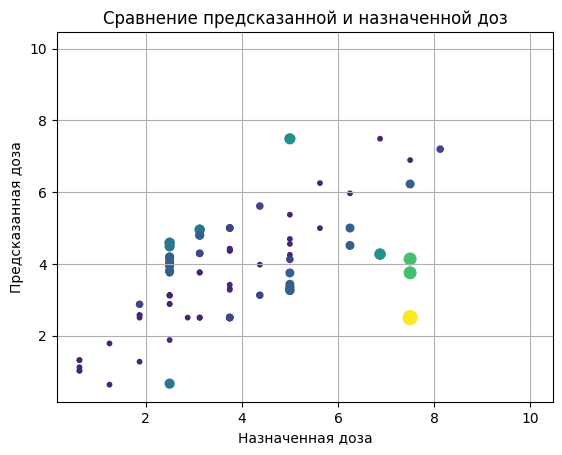

In [30]:
# Разделение данных на обучающий и тестовый наборы (не используя функцию simplified_stratified_split)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

# Опытным путем проверено, что наибольшая точность получается, если удалить из X,
# следующий набор колонок:

features2remove = ['dose','pass_dose','sample','date_diff']

X_train = train_df.drop(columns=features2remove, axis=1)
y_train = train_df['dose']
X_test = test_df.drop(columns=features2remove, axis=1)
y_test = test_df['dose']

# Тот же пайплайн для регресии
pipe = Pipeline([('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
('oh-enc', OneHotEncoder(cols=[])),
('target_enc', TargetEncoder(cols=[])),
('imputation', SimpleImputer(strategy='median')),
('1', FeatureAgglomeration(affinity='manhattan', linkage='average')),
('0', KNeighborsRegressor(n_neighbors=93, p=1, weights='distance'))])

# Обучение пайплайна 
pipe.fit(X_train, y_train)

### Прогноз и расчет точности на полном наборе данных
# X_test = df.drop(columns=features2remove, axis=1)
# y_test = df['dose']

# предсказание
predictions = pipe.predict(X_test)
rpredictions = [round(x,3) for x in predictions] # округление до точности исходных данных

# Рассчитываем основные метрики
mae = mean_absolute_error(y_test, rpredictions)
mse = mean_squared_error(y_test, rpredictions)
r2 = r2_score(y_test, rpredictions)
mape_value = np.mean(np.abs((y_test - rpredictions) / y_test)) * 100
abs_diff = np.abs(y_test - rpredictions)
diff_below_threshold = (abs_diff <= 0.5).sum()
total_predictions = len(rpredictions)
percentage_diff = (diff_below_threshold / total_predictions) * 100

# Выводим результаты
print("{:<55} {:>5.2f}".format("Средняя абсолютная ошибка (MAE):", mae))
print("{:<55} {:>5.2f}".format("Среднеквадратичная ошибка (MSE):", mse))
print("{:<55} {:>5.2f}".format("Коэффициент детерминации (R^2):", r2))
print("{:<55} {:>5.2f}%".format("Средняя абсолютная процентная ошибка (MAPE):", mape_value))
print("{:<55} {:>5.2f}%".format("Доля предсказаний с отклонением не более 0,5 мг:", percentage_diff))

ae = round(abs(y_test - rpredictions)/0.5)
col = ae
size = ae*10
plt.scatter(y_test, rpredictions, marker='o', c=col,  s=size)
plt.title('Сравнение предсказанной и назначенной доз')
plt.ylabel('Предсказанная доза')
plt.xlabel('Назначенная доза');
plt.grid()
plt.show()

**Выводы:**
1. После удаления 4 записей (с самой большой ошибкой) точность прогноза увеличилась на 2%
2. Удаление большего числа записей к увеличению точности не привело
3. Эти 4 записи можно считать выбросами в данных (?)

Дальнейшие действия:
1. Подготовить данные без этих 4 строк и повторить подбор самого оптимального пайплайна на наборе без выбросов. Убедиться, что это дает дальнейшее увеличение точности модели.
2. Исследовать другие записи, дающие ошибки выше порога, для нахождения дополнительных трансформаций данных, направленных на повышение точности прогнза


### Наивные эксперименты по определению основных колонок, влияющих на увеличение ошибки прогноза с помощью линейной регрессии 

In [1]:
from sklearn.linear_model import LinearRegression

X = dd.drop(columns=['pred', 'diff', 'mape'], axis=1)
y = dd['mape']


reg = LinearRegression(fit_intercept=True).fit(X, y)
print(reg.score(X, y))

print(reg.coef_,'\n', len(reg.coef_))
reg.intercept_

# >>> reg.predict(np.array([[3, 5]]))
# array([16.])

NameError: name 'dd' is not defined

In [23]:
ft = pd.DataFrame(zip(X.columns,reg.coef_), columns=['feature','coef']).sort_values(by='coef',ascending=False)
ft.head()

,feature,coef
10,age_level,4.956543
4,mitral_valve,4.537196
48,zodiac_Pisces,4.217146
53,gender_0,3.300505
52,zodiac_Virgo,2.862576


In [25]:
ft[ft['coef']!=0]

,feature,coef
10,age_level,4.956543e+00
4,mitral_valve,4.537196e+00
48,zodiac_Pisces,4.217146e+00
53,gender_0,3.300505e+00
52,zodiac_Virgo,2.862576e+00
19,d3,2.047900e+00
83,institution_id_29,1.950393e+00
9,pass_dose,1.434937e+00
16,age_level6,1.363162e+00
65,institution_id_11,1.131258e+00


In [26]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

X = dd.drop(columns=['pred', 'diff', 'mape'], axis=1)
y = dd['mape']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                   mape   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.031e+05
Date:                Fri, 13 Oct 2023   Prob (F-statistic):           2.22e-10
Time:                        11:35:27   Log-Likelihood:                 9.0932
No. Observations:                  16   AIC:                             5.814
Df Residuals:                       4   BIC:                             15.08
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
id                     8.771e-

C:\Users\Sovtsov\AutoML\lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
